In [2]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score,precision_score, recall_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
# import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scripts.SEP_CFE_functions import *



min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")
# scale_factor = 1e8

In [3]:
# --- Patch DiCE PublicData.get_decimal_precisions early to avoid IndexError in empty/malformed modes ---
import dice_ml.data_interfaces.public_data_interface as pdi

def safe_get_decimal_precisions(self, output_type="list"):
    """Return decimal precision per feature safely.

    Returns a list by default (same shape as original DiCE implementation) where each
    index corresponds to the feature order in `self.feature_names`. Also supports
    output_type='dict' to return a mapping {feature_name: precision}.

    This is defensive: if modes are empty or unparsable the default precision is 6.
    """
    from collections import defaultdict
    precisions_dict = defaultdict(int)
    # initialize a list matching feature_names length (default 0)
    precisions_list = [0] * len(self.feature_names)

    for idx, feat in enumerate(self.feature_names):
        # default precision
        precisions_list[idx] = 6
        precisions_dict[feat] = 6

    # Now compute precisions for continuous features only
    for col in self.continuous_feature_names:
        try:
            # determine index of this feature in feature_names
            try:
                ix = self.feature_names.index(col)
            except ValueError:
                # fallback: place precision at leftmost free slot (shouldn't normally happen)
                ix = None

            if (self.continuous_features_precision is not None) and (col in self.continuous_features_precision):
                prec = int(self.continuous_features_precision[col])
            else:
                # only compute modes if dtype is float-like
                if getattr(self.data_df[col], 'dtype', None) in [np.float32, np.float64]:
                    modes = self.data_df[col].mode()
                    if len(modes) == 0:
                        prec = 6
                    else:
                        # compute maximal fractional length among modes
                        maxp = 0
                        for m in modes:
                            s = str(m)
                            if '.' in s:
                                parts = s.split('.')
                                if len(parts) > 1:
                                    maxp = max(maxp, len(parts[1]))
                        prec = maxp if maxp > 0 else 6
                else:
                    prec = 6
            # set into both structures
            if ix is not None:
                precisions_list[ix] = prec
            precisions_dict[col] = prec
        except Exception:
            # any unexpected error -> keep default precision 6
            precisions_dict[col] = 6
            try:
                if ix is not None:
                    precisions_list[ix] = 6
            except Exception:
                pass

    if output_type == "list":
        return precisions_list
    elif output_type == "dict":
        return dict(precisions_dict)
    else:
        # preserve backward compatibility: return list by default for any unknown output_type
        return precisions_list

# Apply the patch so subsequent DiCE calls use this safe version
pdi.PublicData.get_decimal_precisions = safe_get_decimal_precisions

In [5]:
abt_path_train = '../../data/raw/GOES/goes18_2024.csv'
df_train = pd.read_csv(abt_path_train,  sep=',' )
df_train.columns.values[0] = 'timestamp'
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

In [ ]:
print(df_train[["xrsa","xrsb"]].min())
print(df_train[["xrsa","xrsb"]].max())

In [6]:
def create_and_save_windows(df, save_dir="windows", input_hours=2, pred_hours=2, stride_hours=2):
    os.makedirs(save_dir, exist_ok=True)
    input_len = input_hours * 60     # convert to minutes
    pred_len = pred_hours * 60
    stride = stride_hours * 60
    n = len(df)
    timestamps = df['timestamp']
    window_count = 0

    for start in range(0, n - input_len - pred_len + 1, stride):
        end_input = start + input_len
        end_pred = end_input + pred_len

        input_df = df.iloc[start:end_input]
        pred_df  = df.iloc[end_input:end_pred]

        start_time = timestamps[start].strftime("%Y%m%d_%H%M")
        input_file = os.path.join(save_dir, f"GOES18_2024_{window_count:04d}_{start_time}_input.csv")
        pred_file  = os.path.join(save_dir, f"GOES18_2024_{window_count:04d}_{start_time}_pred.csv")

        input_df.to_csv(input_file)
        pred_df.to_csv(pred_file)
        window_count += 1
    print(f"✅ Created {window_count} overlapping windows in '{save_dir}'")

# Create and save windows with stride = 2 hours
create_and_save_windows(df_train, save_dir="../../data/processed/goes18_2024", input_hours=2, pred_hours=2, stride_hours=2)

✅ Created 4391 overlapping windows in '../../data/processed/goes18_2024'


In [38]:
def create_flare_label_dataset_from_pred(input_pred_dir, save_path=None):
    rows = []
    for file in sorted(os.listdir(input_pred_dir)):
        if file.endswith("_pred.csv"):
            pred_file_path = os.path.join(input_pred_dir, file)
            df_pred = pd.read_csv(pred_file_path)

            max_flux = df_pred['xrsb'].max()
            if max_flux >= 1e-4:
                label = 'X'
            elif max_flux >= 1e-5:
                label = 'M'
            elif max_flux >= 1e-6:
                label = 'C'
            elif max_flux >= 1e-7:
                label = 'B'
            elif max_flux >= 1e-8:
                label = 'A'
            else:
                label = 'NF'

            input_filename = file.replace('_pred', '_input')
            rows.append({'input_filename': input_filename, 'label': label})

    label_df = pd.DataFrame(rows)
    if save_path:
        label_df.to_csv(save_path, index=False)
        print(f"Label dataset saved to: {save_path}")

    return label_df


In [39]:
input_pred_dir = "../../data/processed/goes18_2024"
save_file = "../../data/processed/goes18_2024_labels.csv"

label_df = create_flare_label_dataset_from_pred(input_pred_dir, save_path=save_file)
print(label_df.head())

Label dataset saved to: ../../data/processed/goes18_2024_labels.csv
                             input_filename label
0  GOES18_2024_0000_20240101_0000_input.csv     C
1  GOES18_2024_0001_20240101_0200_input.csv     C
2  GOES18_2024_0002_20240101_0400_input.csv     C
3  GOES18_2024_0003_20240101_0600_input.csv     M
4  GOES18_2024_0004_20240101_0800_input.csv     C


In [40]:
# label_df = pd.read_csv("../../data/processed/goes18_2024_labels.csv")

In [41]:
def recursive_slices(start, end, min_size=5):
    length = end - start
    if length <= min_size:
        return [(start, end)]
    else:
        mid = start + length // 2
        left = recursive_slices(start, mid, min_size)
        right = recursive_slices(mid, end, min_size)
        return [(start, end)] + left + right

def generate_mean_features(df, min_size=5, prefix=None):
    n_timesteps = df.shape[0]
    slices = recursive_slices(0, n_timesteps, min_size)
    features = {}

    for channel in ['xrsa', 'xrsb']:
        data = pd.to_numeric(df[channel], errors='coerce').values
        for (s, e) in slices:
            name = f"{prefix+'_' if prefix else ''}{channel}[{s}:{e}]_mean"
            val = np.mean(data[s:e])

            # Only add feature if val is not NaN
            if not np.isnan(val):
                # features[name] = val*scale_factor
                val = np.log(val.clip(min=1e-10))   # natural log, safe for small values
                features[name] = val

    return pd.Series(features)



In [42]:
def create_mean_features_by_window_sizes(input_dir, output_file, window_sizes=None):
    rows = []
    input_files = sorted([f for f in os.listdir(input_dir) if "_input.csv" in f])
    for file in input_files:
        df = pd.read_csv(os.path.join(input_dir, file))
        features = generate_mean_features(df, min_size=5)
        feature_dict = {'input_filename': file, **features.to_dict()}
        rows.append(feature_dict)

    features_df = pd.DataFrame(rows)
    features_df.dropna(inplace=True)
    features_df.to_csv(output_file, index=False)
    print(f"✅ Mean-valued features saved to: {output_file}")


In [43]:
input_dir = "../../data/processed/goes18_2024/"  # folder containing input files
output_file = "../../data/processed/goes18_2024_mean_features_custom_windows.csv"

create_mean_features_by_window_sizes(input_dir, output_file)

✅ Mean-valued features saved to: ../../data/processed/goes18_2024_mean_features_custom_windows.csv


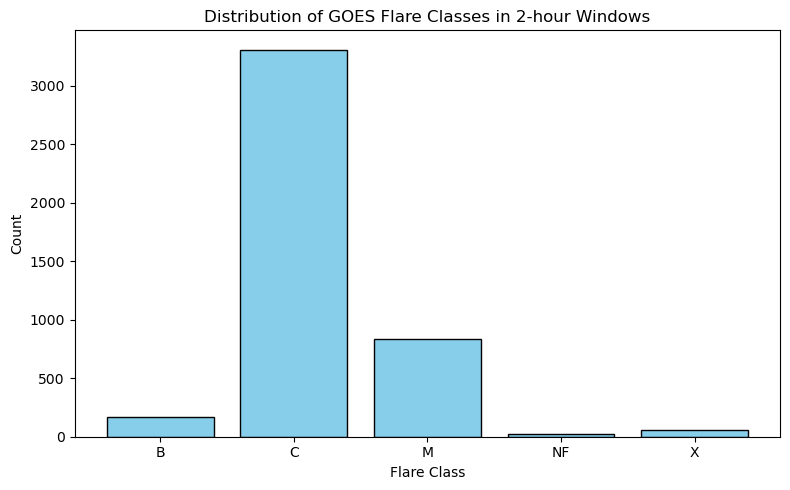

In [44]:
# Count of each flare type
flare_counts = label_df['label'].value_counts().sort_index()  # sort by label

plt.figure(figsize=(8,5))
plt.bar(flare_counts.index, flare_counts.values, color='skyblue', edgecolor='black')
plt.xlabel("Flare Class")
plt.ylabel("Count")
plt.title("Distribution of GOES Flare Classes in 2-hour Windows")
plt.tight_layout()
plt.show()



In [45]:
features_file = "../../data/processed/goes18_2024_mean_features_custom_windows.csv"
features_df = pd.read_csv(features_file)
combined_df = pd.merge(features_df, label_df, on="input_filename", how="inner")

print("Combined dataset shape:", combined_df.shape)
print(combined_df.head())

# Optionally, save to CSV
combined_file = "../../data/processed/goes18_2024_features_labels.csv"
combined_df.to_csv(combined_file, index=False)
print(f"✅ Combined dataset saved to: {combined_file}")


Combined dataset shape: (3888, 128)
                             input_filename  xrsa[0:120]_mean  \
0  GOES18_2024_0000_20240101_0000_input.csv        -15.954489   
1  GOES18_2024_0001_20240101_0200_input.csv        -17.479659   
2  GOES18_2024_0002_20240101_0400_input.csv        -18.424144   
3  GOES18_2024_0003_20240101_0600_input.csv        -17.975338   
4  GOES18_2024_0004_20240101_0800_input.csv        -14.367647   

   xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  xrsa[0:7]_mean  \
0       -15.657441       -15.424716       -15.259331      -15.154179   
1       -17.286852       -17.164607       -17.122758      -17.109607   
2       -18.333628       -18.191758       -18.155167      -18.158065   
3       -18.256867       -18.558373       -18.108273      -17.665172   
4       -13.841311       -15.294633       -14.865567      -14.660659   

   xrsa[0:3]_mean  xrsa[3:7]_mean  xrsa[7:15]_mean  xrsa[7:11]_mean  ...  \
0      -15.095318      -15.200715       -15.361385       -15.312

In [46]:
binary_map = {'NF': 0,'A': 0,'B': 0,'C': 0,'M': 1,'X': 1}
combined_df['binary_label'] = combined_df['label'].map(binary_map)
print(combined_df['binary_label'].value_counts())
print(combined_df[['label', 'binary_label']].head())
combined_file = "../../data/processed/goes18_2024_features_labels.csv"
combined_df.to_csv(combined_file, index=False)
print(f"✅ Combined dataset saved to: {combined_file}")


binary_label
0    3071
1     817
Name: count, dtype: int64
  label  binary_label
0     C             0
1     C             0
2     C             0
3     M             1
4     C             0
✅ Combined dataset saved to: ../../data/processed/goes18_2024_features_labels.csv


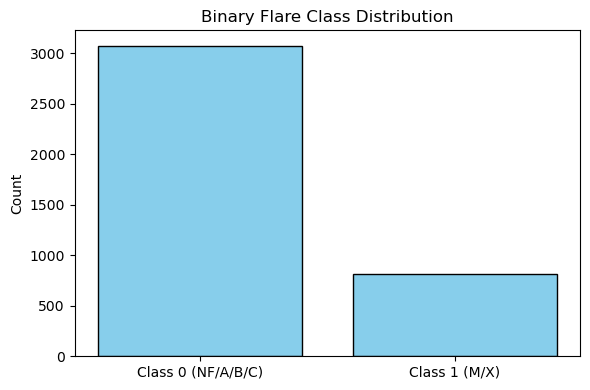

In [47]:
binary_counts = combined_df['binary_label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(binary_counts.index, binary_counts.values, color="skyblue", edgecolor='black')
plt.xticks([0, 1], ["Class 0 (NF/A/B/C)", "Class 1 (M/X)"])
plt.ylabel("Count")
plt.title("Binary Flare Class Distribution")
plt.tight_layout()
plt.show()

In [48]:
def split_df_by_percentage(df, train_frac=0.7, val_frac=0.15, test_frac=0.15, random_state=42):
    if abs(train_frac + val_frac + test_frac - 1.0) > 1e-6:
        raise ValueError("Fractions must sum to 1.0")

    train_df, temp_df = train_test_split(df, train_size=train_frac, random_state=random_state, shuffle=True)
    temp_frac = test_frac / (val_frac + test_frac)
    val_df, test_df = train_test_split(temp_df, test_size=temp_frac, random_state=random_state, shuffle=True)
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


train_df, val_df, test_df = split_df_by_percentage(combined_df)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (2721, 129)
Validation shape: (583, 129)
Test shape: (584, 129)


In [49]:
feature_cols = [c for c in train_df.columns if c not in ['input_filename', 'label', 'binary_label']]
# mm_scaler = MinMaxScaler()
# scaled_train_df = mm_scaler.fit_transform(train_df[feature_cols].values)
# scaled_test_df = mm_scaler.fit_transform(test_df[feature_cols].values)
# scaled_val_df = mm_scaler.fit_transform(val_df[feature_cols].values)

# X_train = train_df[feature_cols].values * scale_factor
# y_train = train_df['binary_label'].values
#
# X_val = val_df[feature_cols].values * scale_factor
# y_val = val_df['binary_label'].values
#
# X_test = test_df[feature_cols].values *scale_factor
# y_test = test_df['binary_label'].values

X_train = train_df[feature_cols].values
y_train = train_df['binary_label'].values

X_val = val_df[feature_cols].values
y_val = val_df['binary_label'].values

X_test = test_df[feature_cols].values
y_test = test_df['binary_label'].values


# X_train = mm_scaler.fit_transform(X_train)
# X_val = mm_scaler.transform(X_val)
# X_test = mm_scaler.transform(X_test)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes:
X_train: (2721, 126) y_train: (2721,)
X_val: (583, 126) y_val: (583,)
X_test: (584, 126) y_test: (584,)


In [50]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 70, 100, 200, 300, 400],
    'max_depth': [2, 3, 4, 5, 6, 7, 8]
}
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid,cv=cv,scoring=scorer,n_jobs=-1,verbose=1)

grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score from cross-validation
print("Best parameters found:", grid_search.best_params_)
print("Best F1 score (for positive class) from CV:", grid_search.best_score_)

# Retrieve the best estimator and evaluate on the test data
best_rf = grid_search.best_estimator_
Y_pred = best_rf.predict(X_train)

# Save model
joblib.dump(best_rf, '../../models/RandomForestClassifier_model_goes18_xrs_cfe.pkl')

# Output the test classification report and confusion matrix
print("\nTest Classification Report:\n", classification_report(y_train, Y_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_train, Y_pred))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found: {'max_depth': 4, 'n_estimators': 300}
Best F1 score (for positive class) from CV: 0.5358550494900873

Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86      2154
           1       0.50      0.65      0.57       567

    accuracy                           0.79      2721
   macro avg       0.70      0.74      0.72      2721
weighted avg       0.82      0.79      0.80      2721

Test Confusion Matrix:
 [[1793  361]
 [ 199  368]]


In [51]:
overall_results = []
overall_results.append(('training set', TSS(y_train, Y_pred), HSS(y_train, Y_pred),accuracy_score(y_train, Y_pred),precision_score(y_train, Y_pred),f1_score(y_train, Y_pred),recall_score(y_train, Y_pred)))

y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set', TSS(y_val, y_val_pred), HSS(y_val, y_val_pred),accuracy_score(y_val, y_val_pred),precision_score(y_val, y_val_pred),f1_score(y_val, y_val_pred),recall_score(y_val, y_val_pred)))

y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set', TSS(y_test, y_test_pred), HSS(y_test, y_test_pred),accuracy_score(y_test, y_test_pred),precision_score(y_test, y_test_pred),f1_score(y_test, y_test_pred),recall_score(y_test, y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset",  "TSS", "HSS","Accuracy","Precision Score","F1_score","Recall_score"]))


          Dataset       TSS       HSS  Accuracy  Precision Score  F1_score  \
0    training set  0.481435  0.435588  0.794193         0.504801  0.567901   
1  validation set  0.423541  0.390641  0.773585         0.487342  0.538462   
2     testing set  0.529593  0.466304  0.799658         0.514970  0.595156   

   Recall_score  
0      0.649030  
1      0.601562  
2      0.704918  


                Feature  Importance
125  xrsb[116:120]_mean    0.092562
123  xrsb[112:120]_mean    0.083808
62   xrsa[116:120]_mean    0.068906
119  xrsb[105:120]_mean    0.052068
124  xrsb[112:116]_mean    0.051413
111   xrsb[90:120]_mean    0.048482
60   xrsa[112:120]_mean    0.043314
48    xrsa[90:120]_mean    0.038869
122  xrsb[108:112]_mean    0.028301
61   xrsa[112:116]_mean    0.027441
56   xrsa[105:120]_mean    0.025032
95    xrsb[60:120]_mean    0.023638
120  xrsb[105:112]_mean    0.021560
63     xrsb[0:120]_mean    0.020783
32    xrsa[60:120]_mean    0.018733
59   xrsa[108:112]_mean    0.016961
0      xrsa[0:120]_mean    0.016329
112   xrsb[90:105]_mean    0.010964
105    xrsb[75:82]_mean    0.010135
57   xrsa[105:112]_mean    0.010112


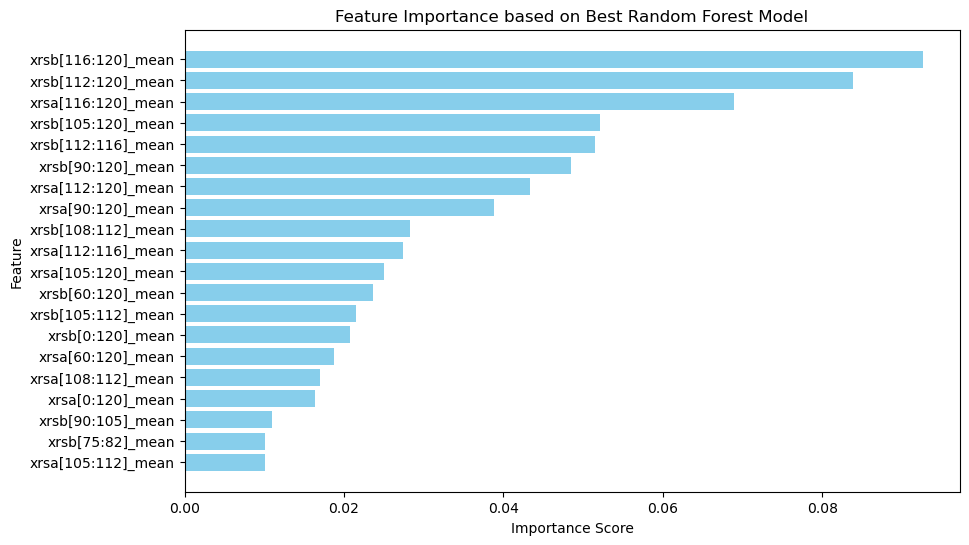

In [52]:
feature_importances = best_rf.feature_importances_
cont_features = list(combined_df.drop(["input_filename","label","binary_label"],axis=1).columns)
feature_importance_df = pd.DataFrame({
    'Feature': cont_features,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)
print(feature_importance_df)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

Creating DiCE Counterfactual Explainers for SEP Prediction

In [53]:
df_cfe=combined_df.drop(["input_filename","label",],axis=1)
# df_cfe = test_df.drop(["label","input_filename"],axis=1)
df_cfe['binary_label']=df_cfe['binary_label'].astype(float)
# --- Clean continuous features so every column has a visible decimal part ---
for col in cont_features:
    # Force float, replace inf/nan
    df_cfe[col] = pd.to_numeric(df_cfe[col], errors='coerce').fillna(0).astype(float)
    # Round and force decimal representation
    df_cfe[col] = df_cfe[col].apply(lambda x: float(f"{x:.10f}"))
print(df_cfe.dtypes)       # all float64
print(df_cfe.isna().sum()) # all zeros
print(df_cfe.head())
print(df_cfe.columns)


xrsa[0:120]_mean      float64
xrsa[0:60]_mean       float64
xrsa[0:30]_mean       float64
xrsa[0:15]_mean       float64
xrsa[0:7]_mean        float64
                       ...   
xrsb[108:112]_mean    float64
xrsb[112:120]_mean    float64
xrsb[112:116]_mean    float64
xrsb[116:120]_mean    float64
binary_label          float64
Length: 127, dtype: object
xrsa[0:120]_mean      0
xrsa[0:60]_mean       0
xrsa[0:30]_mean       0
xrsa[0:15]_mean       0
xrsa[0:7]_mean        0
                     ..
xrsb[108:112]_mean    0
xrsb[112:120]_mean    0
xrsb[112:116]_mean    0
xrsb[116:120]_mean    0
binary_label          0
Length: 127, dtype: int64
   xrsa[0:120]_mean  xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  \
0        -15.954489       -15.657441       -15.424716       -15.259331   
1        -17.479659       -17.286852       -17.164607       -17.122758   
2        -18.424144       -18.333628       -18.191758       -18.155167   
3        -17.975338       -18.256867       -18.558373    

In [54]:
df_cfe.head()

,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-15.954489,-15.657441,-15.424716,-15.259331,-15.154179,-15.095318,-15.200715,-15.361385,-15.312828,-15.412422,...,-12.537562,-13.097566,-13.256872,-13.232398,-13.216176,-13.244740,-13.278789,-13.267233,-13.290480,0.0
1,-17.479659,-17.286852,-17.164607,-17.122758,-17.109607,-17.079754,-17.132596,-17.134409,-17.130846,-17.137985,...,-13.593764,-13.588365,-13.580916,-13.610168,-13.603754,-13.615005,-13.556004,-13.556630,-13.555379,0.0
2,-18.424144,-18.333628,-18.191758,-18.155167,-18.158065,-18.109006,-18.196507,-18.152638,-18.153472,-18.151804,...,-13.735167,-13.771999,-13.798231,-13.795368,-13.776359,-13.809866,-13.800742,-13.826758,-13.775386,0.0
3,-17.975338,-18.256867,-18.558373,-18.108273,-17.665172,-17.657160,-17.671223,-18.777387,-18.484500,-19.193342,...,-13.714709,-13.706644,-13.518509,-13.681791,-13.708568,-13.662169,-13.394685,-13.577933,-13.239873,1.0
4,-14.367647,-13.841311,-15.294633,-14.865567,-14.660659,-14.812813,-14.560037,-15.087443,-14.891167,-15.331891,...,-13.462045,-13.558684,-13.674382,-13.630034,-13.613388,-13.642703,-13.714868,-13.705760,-13.724059,0.0


In [75]:
# import dice_ml.data_interfaces.public_data_interface as pdi
#
# def safe_get_decimal_precisions(self, output_type="dict"):
#     precisions = {}
#     for col in self.data_df.columns:
#         if self.data_df[col].dtype in [np.float32, np.float64]:
#             modes = self.data_df[col].mode()
#             if len(modes) == 0:
#                 precisions[col] = 6
#                 continue
#             val_str = str(modes[0])
#             precisions[col] = len(val_str.split('.')[1]) if '.' in val_str else 6
#         else:
#             precisions[col] = 6
#     return precisions
#
# pdi.PublicData.get_decimal_precisions = safe_get_decimal_precisions
# print("✅ Patched DiCE precision function safely.")


In [55]:
for feat in cont_features:
    df_cfe[feat]=df_cfe[feat].astype(float)

# Ensure column names are strings to avoid mismatches with DiCE internals
# and update cont_features to be string-typed as well
df_cfe.columns = df_cfe.columns.map(str)
cont_features = [str(c) for c in cont_features]

# Create Data object
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name="binary_label")

In [56]:
# Create model wrapper
cfe_model = dice_ml.Model(
    model=best_rf,
    backend="sklearn",
    model_type='classifier'
)
exp_genetic = dice_ml.Dice(
    data_interface=data,
    model_interface=cfe_model,
    method="genetic"
)
joblib.dump(exp_genetic, "../../models/goes18_xrs_2024_cfe_genetic_explainer.pkl")
print("\nGenetic Dice explainer created successfully.\n")


exp_random = dice_ml.Dice(
    data_interface=data,
    model_interface=cfe_model,
    method="random"
)
joblib.dump(exp_random, "../../models/goes18_xrs_2024_cfe_random_explainer.pkl")

print("\nRandom Dice explainer created successfully.\n")


Genetic Dice explainer created successfully.


Random Dice explainer created successfully.



In [57]:
def get_filtered_min_max(df, feature_cols):
    min_max_dict = {}
    for col in feature_cols:
        min_val = df[col].min()
        max_val = df[col].max()
        min_max_dict[col] = [min_val, max_val]
    return min_max_dict

In [58]:
df = pd.read_csv("../../data/processed/goes18_2024_features_labels.csv")
df[cont_features] = df[cont_features].astype(float)
min_max_dict = get_filtered_min_max(df, cont_features)
print(min_max_dict)

{'xrsa[0:120]_mean': [-20.722311423377302, -10.19829753019591], 'xrsa[0:60]_mean': [-20.72326583694641, -9.757695305526733], 'xrsa[0:30]_mean': [-20.72326583694641, -9.395494574770362], 'xrsa[0:15]_mean': [-20.72326583694641, -9.805798540156498], 'xrsa[0:7]_mean': [-20.72326583694641, -9.669760139832766], 'xrsa[0:3]_mean': [-20.72326583694641, -9.603535258102298], 'xrsa[3:7]_mean': [-20.72326583694641, -9.72247573641148], 'xrsa[7:15]_mean': [-20.72326583694641, -9.861812500373029], 'xrsa[7:11]_mean': [-20.72326583694641, -9.680611749063171], 'xrsa[11:15]_mean': [-20.72326583694641, -9.98099256039533], 'xrsa[15:30]_mean': [-20.72326583694641, -8.707124474875732], 'xrsa[15:22]_mean': [-20.72326583694641, -8.38143150961164], 'xrsa[15:18]_mean': [-20.72326583694641, -8.69223807751195], 'xrsa[18:22]_mean': [-20.72326583694641, -8.198811426523573], 'xrsa[22:30]_mean': [-20.72326583694641, -9.117903133299766], 'xrsa[22:26]_mean': [-20.72326583694641, -8.837350901607868], 'xrsa[26:30]_mean': [

In [59]:
def get_query_instance(query_ts_filename, df_combined_labels, model):
    """
    Retrieve the query instance and its target label for a given filename.

    Args:
           query_ts_filename (str): The filename identifying the query instance.
           df_combined_labels (pd.DataFrame): DataFrame containing labeled data.
           model: A trained classifier with a `.predict()` method.

    Returns:
        Tuple[pd.DataFrame, Any]: The query instance (features only) and its true label.
     """
    query_instance_raw = df_combined_labels[df_combined_labels['input_filename'] == query_ts_filename]
    query_instance = query_instance_raw.drop(["label", 'input_filename','binary_label'], axis=1)
    query_instance = query_instance.fillna(0)
    true_label = query_instance_raw["binary_label"].values[0]
    predicted_label = model.predict(query_instance)

    print("Target value for the query instance:\n", true_label)
    print("Predicted value:\n", predicted_label)

    return query_instance, true_label, predicted_label

In [60]:
query_ts1_filename ='GOES18_2024_3628_20241029_0800_input.csv'
# query_ts1_filename ='GOES18_2024_4390_20241231_2000_input.csv'
# query_ts1_filename ='GOES18_2024_0026_20240103_0400_input.csv'
query_instance1, target_val1,predicted_val= get_query_instance(query_ts1_filename, df_combined_labels=combined_df, model=best_rf)
query_instance1 = query_instance1.astype(float)
query_instance1 = query_instance1.fillna(0)
print(query_instance1)

Target value for the query instance:
 0
Predicted value:
 [1]
      xrsa[0:120]_mean  xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  \
3164        -15.809861       -15.595251       -15.266799       -15.181361   

      xrsa[0:7]_mean  xrsa[0:3]_mean  xrsa[3:7]_mean  xrsa[7:15]_mean  \
3164       -15.14522      -15.138745      -15.150103       -15.214092   

      xrsa[7:11]_mean  xrsa[11:15]_mean  ...  xrsb[97:105]_mean  \
3164       -15.179784        -15.249619  ...         -12.454402   

      xrsb[97:101]_mean  xrsb[101:105]_mean  xrsb[105:120]_mean  \
3164         -12.444616          -12.464286          -12.536816   

      xrsb[105:112]_mean  xrsb[105:108]_mean  xrsb[108:112]_mean  \
3164          -12.534076          -12.505876           -12.55576   

      xrsb[112:120]_mean  xrsb[112:116]_mean  xrsb[116:120]_mean  
3164          -12.539219          -12.558499          -12.520304  

[1 rows x 126 columns]


In [61]:
# Generate counterfactuals
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance1,
    total_CFs=4,
    permitted_range=min_max_dict,
    desired_class=1
)
cfe_genetic.visualize_as_dataframe(show_only_changes=True)
cfe_df_genetic = cfe_genetic.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:13<00:00, 13.63s/it]

Query instance (original outcome : 1)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-15.809861,-15.595251,-15.266799,-15.181361,-15.14522,-15.138745,-15.150104,-15.214092,-15.179785,-15.249619,...,-12.444615,-12.464286,-12.536816,-12.534076,-12.505877,-12.55576,-12.539219,-12.558499,-12.520305,1



Diverse Counterfactual set (new outcome: 1)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
0,-16.041629791259766,-15.8117504119873,-15.5909652709961,-15.6088275909424,-15.7759866714478,-15.9724197387695,-15.6504487991333,-15.4824647903442,-15.4946403503418,-15.4704360961914,...,-,-12.398199081420898,-12.359607696533203,-12.3513298034668,-12.341808319091797,-12.35853099822998,-12.366907119750977,-12.393048286437988,-12.341431617736816,-


In [62]:
query_ts2_filename ='GOES18_2024_4390_20241231_2000_input.csv'
# query_ts1_filename ='GOES18_2024_0026_20240103_0400_input.csv'
query_instance2, target_val2,predicted_val= get_query_instance(query_ts2_filename, df_combined_labels=combined_df, model=best_rf)
query_instance2 = query_instance2.astype(float)
query_instance2 = query_instance2.fillna(0)
print(query_instance2)

Target value for the query instance:
 1
Predicted value:
 [1]
      xrsa[0:120]_mean  xrsa[0:60]_mean  xrsa[0:30]_mean  xrsa[0:15]_mean  \
3887        -14.466676       -16.990677       -17.019777        -16.86546   

      xrsa[0:7]_mean  xrsa[0:3]_mean  xrsa[3:7]_mean  xrsa[7:15]_mean  \
3887      -16.813838      -16.812684      -16.814704       -16.912924   

      xrsa[7:11]_mean  xrsa[11:15]_mean  ...  xrsb[97:105]_mean  \
3887       -16.859874        -16.968948  ...          -10.97994   

      xrsb[97:101]_mean  xrsb[101:105]_mean  xrsb[105:120]_mean  \
3887         -11.075783          -10.892485          -10.809067   

      xrsb[105:112]_mean  xrsb[105:108]_mean  xrsb[108:112]_mean  \
3887          -10.796345           -10.81125           -10.78531   

      xrsb[112:120]_mean  xrsb[112:116]_mean  xrsb[116:120]_mean  
3887          -10.820333           -10.79808          -10.843092  

[1 rows x 126 columns]


In [66]:
combined_df[combined_df['input_filename'] == query_ts2_filename]

,input_filename,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,...,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,label,binary_label
3887,GOES18_2024_4390_20241231_2000_input.csv,-14.466676,-16.990677,-17.019777,-16.86546,-16.813838,-16.812684,-16.814704,-16.912924,-16.859874,...,-10.892485,-10.809067,-10.796345,-10.81125,-10.78531,-10.820333,-10.79808,-10.843092,M,1


In [64]:
# Generate counterfactuals
cfe_genetic2 = exp_genetic.generate_counterfactuals(
    query_instance2,
    total_CFs=1,
    permitted_range=min_max_dict,
    desired_class=0
)
cfe_genetic2.visualize_as_dataframe(show_only_changes=True)
cfe_df_genetic2 = cfe_genetic2.cf_examples_list[0].final_cfs_df

100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

Query instance (original outcome : 1)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-14.466677,-16.990677,-17.019777,-16.865459,-16.813837,-16.812683,-16.814705,-16.912924,-16.859873,-16.968948,...,-11.075783,-10.892486,-10.809067,-10.796345,-10.81125,-10.78531,-10.820333,-10.79808,-10.843092,1



Diverse Counterfactual set (new outcome: 0)


,xrsa[0:120]_mean,xrsa[0:60]_mean,xrsa[0:30]_mean,xrsa[0:15]_mean,xrsa[0:7]_mean,xrsa[0:3]_mean,xrsa[3:7]_mean,xrsa[7:15]_mean,xrsa[7:11]_mean,xrsa[11:15]_mean,...,xrsb[97:101]_mean,xrsb[101:105]_mean,xrsb[105:120]_mean,xrsb[105:112]_mean,xrsb[105:108]_mean,xrsb[108:112]_mean,xrsb[112:120]_mean,xrsb[112:116]_mean,xrsb[116:120]_mean,binary_label
0,-15.582466125488281,-17.3033351898193,-17.3304538726807,-17.2890892028809,-17.2100620269775,-17.1724586486816,-17.2392234802246,-17.3637638092041,-17.3324546813965,-17.3960819244385,...,-12.234378814697266,-12.312114715576172,-12.066014289855959,-11.85530090332031,-11.81198501586914,-11.889065742492676,-12.295727729797363,-12.204813957214355,-12.395740509033203,0.0


In [70]:
import re
def process_header_list(header_list):
    """
    Given a list of column names (e.g. from df.columns.to_list()),
    extract columns matching the pattern:
       <metric>@[<start>:<end>]
    where <metric> is one of: p3_flux_ic_mean, p5_flux_ic_mean, p7_flux_ic_mean, long_mean.

    Returns a list of tuples:
         (metric, slice_str, start, end)
    """
    pattern = r'^(xrsa|xrsb)\[(\d+:\d+)\]_mean$'
    result = []
    for col in header_list:
        m = re.match(pattern, col)
        if m:
            metric = m.group(1)
            slice_str = m.group(2)
            start, end = map(int, slice_str.split(':'))
            result.append((metric, slice_str, start, end))
    return result

header_list = combined_df.columns.astype(str).str.cat(sep="\t").split()
# Process the header list to extract (metric, slice, start, end)
entries = process_header_list(header_list)
# Group entries by metric.
groups = {}
for metric, slice_str, start, end in entries:
    groups.setdefault(metric, []).append((slice_str, start, end))
# Sort each group by slice start and then end.
for metric in groups:
    groups[metric] = sorted(groups[metric], key=lambda x: (x[1], x[2]))
df_slices = pd.DataFrame(groups)
print(df_slices)



                   xrsa                 xrsb
0           (0:3, 0, 3)          (0:3, 0, 3)
1           (0:7, 0, 7)          (0:7, 0, 7)
2         (0:15, 0, 15)        (0:15, 0, 15)
3         (0:30, 0, 30)        (0:30, 0, 30)
4         (0:60, 0, 60)        (0:60, 0, 60)
..                  ...                  ...
58  (105:120, 105, 120)  (105:120, 105, 120)
59  (108:112, 108, 112)  (108:112, 108, 112)
60  (112:116, 112, 116)  (112:116, 112, 116)
61  (112:120, 112, 120)  (112:120, 112, 120)
62  (116:120, 116, 120)  (116:120, 116, 120)

[63 rows x 2 columns]


In [72]:
def extract_values(column_name):
    extracted_list = []
    for cell in df_slices[column_name]:
        extracted_list.append((cell[1], cell[2]))  # Extract 2nd and 3rd values
    return extracted_list

# Extracting for a specific column
slices = extract_values("xrsa")
print(slices)

[(0, 3), (0, 7), (0, 15), (0, 30), (0, 60), (0, 120), (3, 7), (7, 11), (7, 15), (11, 15), (15, 18), (15, 22), (15, 30), (18, 22), (22, 26), (22, 30), (26, 30), (30, 33), (30, 37), (30, 45), (30, 60), (33, 37), (37, 41), (37, 45), (41, 45), (45, 48), (45, 52), (45, 60), (48, 52), (52, 56), (52, 60), (56, 60), (60, 63), (60, 67), (60, 75), (60, 90), (60, 120), (63, 67), (67, 71), (67, 75), (71, 75), (75, 78), (75, 82), (75, 90), (78, 82), (82, 86), (82, 90), (86, 90), (90, 93), (90, 97), (90, 105), (90, 120), (93, 97), (97, 101), (97, 105), (101, 105), (105, 108), (105, 112), (105, 120), (108, 112), (112, 116), (112, 120), (116, 120)]


In [115]:
def get_pertubed_series(csv_path, sample_cfe, flux_type, slices, start_offset_min=300, end_offset_min=660):
    df = pd.read_csv(csv_path, delimiter=',')
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    event_start = df['timestamp'].iloc[0] + timedelta(minutes=start_offset_min)
    event_end = df['timestamp'].iloc[0] + timedelta(minutes=end_offset_min)
    df_obs = df[(df['timestamp'] >= event_start) & (df['timestamp'] < event_end)].copy()
    df_obs['minutes'] = (df_obs['timestamp'] - event_start).dt.total_seconds() / 60

    offset_accum = np.zeros_like(df_obs['minutes'], dtype=float)
    offset_count = np.zeros_like(df_obs['minutes'], dtype=int)

    for start_min, end_min in slices:
        slice_data = df_obs[(df_obs['minutes'] >= start_min) & (df_obs['minutes'] < end_min)]
        if slice_data.empty:
            continue
        mask = (df_obs['minutes'] >= start_min) & (df_obs['minutes'] < end_min)
        if np.sum(mask) == 0:
            continue
        flux_data = slice_data[flux_type].values
        pattern = f'^{flux_type}\\[{start_min}:{end_min}\\]_mean$'
        cfe_value = np.exp(sample_cfe.filter(regex=pattern).iloc[0])  # should be a single value
        global_adjustment = cfe_value - flux_data.mean()
        delta = flux_data + global_adjustment
        offset_accum[mask] += delta
        offset_count[mask] += 1

    final_offset = np.zeros_like(df_obs['minutes'], dtype=float)
    nonzero = offset_count > 0
    final_offset[nonzero] = offset_accum[nonzero] / offset_count[nonzero]

    original = df_obs[flux_type].values
    final_series = original + final_offset
    perturbed_series = pd.Series(final_series, index=df_obs.index)
    original_series = pd.Series(original, index=df_obs.index)
    min_y = min(final_series.min(), final_offset.min(), original.min())
    max_y = max(final_series.max(), final_offset.max(), original.max())
    return df_obs, perturbed_series, original_series, min_y, max_y


In [105]:
sample_cfe = cfe_df_genetic2.iloc[0]
df_obs, final_series_xrsa, original_xrsa, min_y_xrsa, max_y_xrsa = get_pertubed_series(
        "../../data/processed/goes18_2024/"+query_ts2_filename, sample_cfe=sample_cfe, flux_type="xrsa", slices=slices,
        start_offset_min=0, end_offset_min=120)


In [110]:
final_series_xrsa

0      3.025269e-08
1      3.080107e-08
2      2.831375e-08
3      2.834858e-08
4      2.541186e-08
           ...     
115    2.211888e-06
116    2.146315e-06
117    2.050316e-06
118    1.970784e-06
119    1.895755e-06
Length: 120, dtype: float64

In [117]:
print(final_series_xrsa.max(),final_series_xrsa.min(),original_xrsa.max(),original_xrsa.min())

3.418962274300124e-06 -8.890607298350847e-08 2.2063973e-06 2.4961412e-08


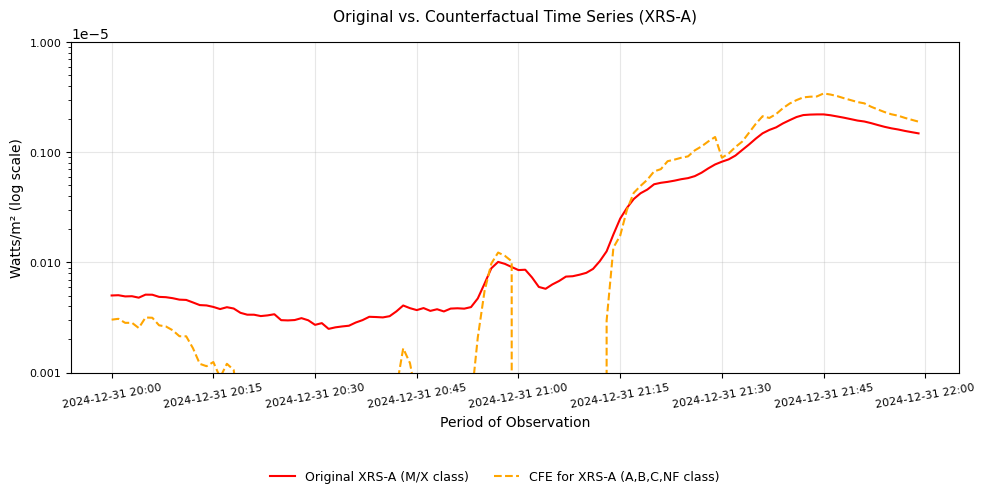

In [119]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 5))

# --- Plot series ---
ax.plot(
    df_obs['timestamp'],
    original_xrsa,
    label="Original XRS-A (M/X class)",
    color="#FF0000",
    linewidth=1.5
)
ax.plot(
    df_obs['timestamp'],
    final_series_xrsa,
    label="CFE for XRS-A (A,B,C,NF class)",
    color="#FFA500",
    linestyle='--',
    linewidth=1.5
)

# --- Axis formatting ---
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Watts/m² (log scale)", fontsize=10)
ax.set_yscale('log')
ax.set_ylim(1e-8, 1e-5)  # typical XRS flare range

ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.setp(ax.get_xticklabels(), rotation=10, ha='center', fontsize=8)
plt.setp(ax.get_yticklabels(), fontsize=8)

# --- Title above plot ---
ax.set_title("Original vs. Counterfactual Time Series (XRS-A)", fontsize=11, pad=15)

# --- Legend below plot ---
fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),   # position below the axis
    ncol=2,
    frameon=False,
    fontsize=9
)

# --- Layout adjustments ---
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space for legend below and title above
plt.grid(alpha=0.3)
plt.show()
